### [Regression Data Analysis]
# KaKR House Price Prediction - Feature Engineering

- EDA에서 진행된 데이터에 대한 이해를 통해 여러가지 feature들을 다루어보며 수정 및 생성해보았습니다.

---

#### Import Modules

In [2]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inlineimport warnings

#### Data Load

In [3]:
data = pd.read_csv("./data/train.csv", index_col=['id'])
test = pd.read_csv("./data/test.csv", index_col=['id'])

# `price`

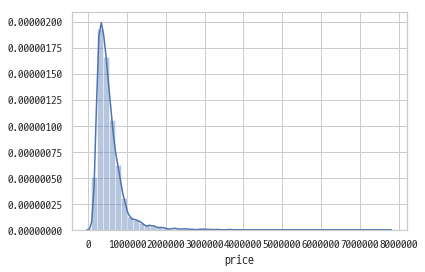

In [4]:
sns.distplot(data['price'])
plt.show()

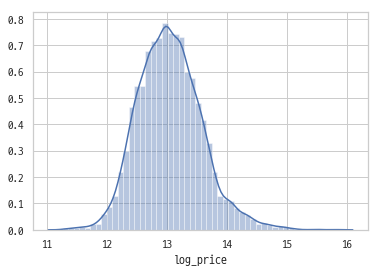

In [5]:
data['log_price'] = np.log1p(data['price'])
sns.distplot(data['log_price'])
plt.show()

- log 변환 한 컬럼으로 대체

# `Date`

In [5]:
data['date'] = data['date'].apply(lambda i: i[:8])
data['date'] = pd.to_datetime(data['date'])
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['day']= data.date.dt.day
data['year_month'] = data.date.dt.year * 100 + data.date.dt.month
data['day_of_week'] = data.date.dt.dayofweek
data[['date', 'year', 'month', 'year_month', 'day', 'day_of_week']].head()

,date,year,month,year_month,day,day_of_week
id,,,,,,
0,2014-10-13,2014,10,201410,13,0
1,2015-02-25,2015,2,201502,25,2
2,2015-02-18,2015,2,201502,18,2
3,2014-06-27,2014,6,201406,27,4
4,2015-01-15,2015,1,201501,15,3


###  `year_month`와 `month` 컬럼의 `log_price`에 따른 변화 확인

In [7]:
year_month_df = data.groupby(['year_month']).mean().sort_values('year_month').reset_index()[['year_month', \
                                                                                             'log_price']]
year_month_df['year_month'] = year_month_df['year_month'].astype(str)

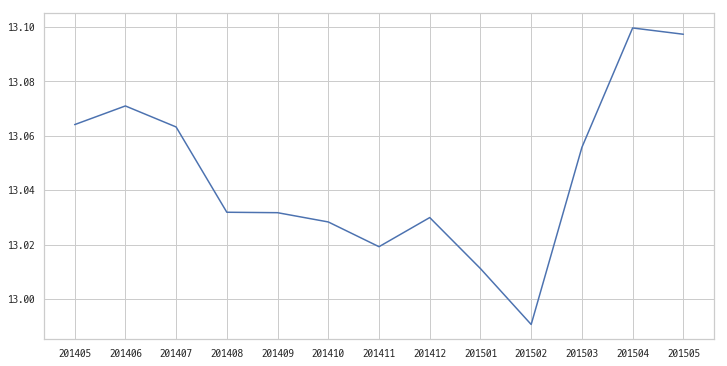

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(year_month_df['year_month'], year_month_df['log_price'])
plt.xticks(year_month_df['year_month'])
plt.show()

In [9]:
month_df = data.groupby(['month']).mean().sort_values('month').reset_index()[['month', \
                                                                                             'log_price']]
month_df['year_month'] = month_df['month'].astype(str)

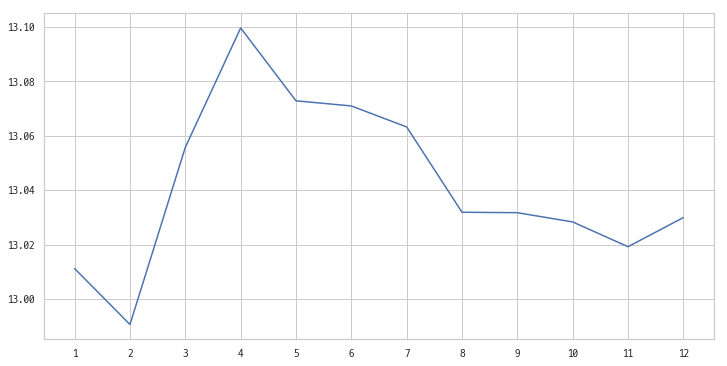

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(month_df['month'], month_df['log_price'])
plt.xticks(month_df['month'])
plt.show()

- `month` 대신에 `year_month`로 사용하기로 한다.
- `year_month`는 min-max scaling해서 사용한다.

### `year`, `Day_of_week` 

- `year` : `2015_or_not` 컬럼을 만들어서 0, 1 이진값을 가지는 컬럼으로 대체
    
    
- `day_of_week` : `weekday`, `saturday`, `sunday` 세 컬럼으로 OHE

In [11]:
data['2014_or_not'] = data.year.apply(lambda i: 0 if i == 2014 else 1)
data['weekday_ohe'] = data.day_of_week.apply(lambda i: 1 if i in range(5) else 0)
data['saturday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 5 else 0)
data['sunday_ohe'] = data.day_of_week.apply(lambda i: 1 if i == 6 else 0)
data[['year', '2014_or_not', 'day_of_week', 'weekday_ohe', 'saturday_ohe', 'sunday_ohe']].head()

,year,2014_or_not,day_of_week,weekday_ohe,saturday_ohe,sunday_ohe
id,,,,,,
0,2014,0,0,1,0,0
1,2015,1,2,1,0,0
2,2015,1,2,1,0,0
3,2014,0,4,1,0,0
4,2015,1,3,1,0,0


In [12]:
data[(data['day_of_week'] == 5) | (data['day_of_week'] == 6)][['day_of_week', 'weekday_ohe', 'saturday_ohe', 'sunday_ohe']].head()

,day_of_week,weekday_ohe,saturday_ohe,sunday_ohe
id,,,,
10,5,0,1,0
42,6,0,0,1
143,6,0,0,1
149,5,0,1,0
176,5,0,1,0


# `bedrooms`

In [13]:
data.bedrooms.value_counts()

3     6835
4     4797
2     1931
5     1108
6      188
1      133
7       22
8       10
9        5
0        4
10       2
Name: bedrooms, dtype: int64

- 0~10개의 방을 가진다

- 개수에 따른 분포에서 너무 큰 편차를 보이므로 적당히 묶기로 한다


- 0~2 : `small`
- 3~4 : `medium`
- 5~10 : `big`

In [14]:
data['bedrooms_size'] = data.bedrooms.apply(lambda i: 'small' if i < 3 else 'medium' if i < 5 else 'big')
data.bedrooms_size.value_counts()

medium    11632
small      2068
big        1335
Name: bedrooms_size, dtype: int64

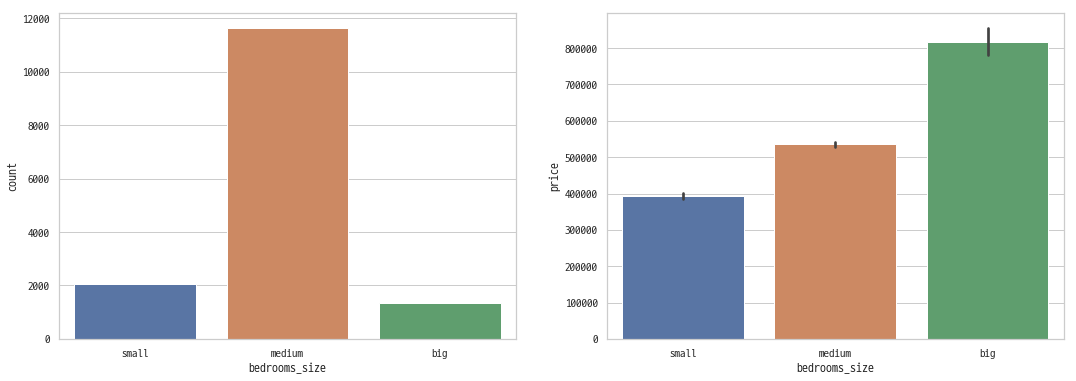

In [15]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="bedrooms_size", order=['small', 'medium', 'big'], ax=ax1)
sns.barplot(data=data, x="bedrooms_size", y="price", order=['small', 'medium', 'big'], ax=ax2)
plt.show()

- `small = 0` / `medium = 0.5` / `big = 1` 로 float값을 주기로 한다

In [16]:
data['bedrooms_grade'] = data.bedrooms_size.apply(lambda i: 0 if i == 'small' else 0.5 if i == 'medium' else 1)
data[['bedrooms', 'bedrooms_size', 'bedrooms_grade']].head(10)

,bedrooms,bedrooms_size,bedrooms_grade
id,,,
0,3,medium,0.5
1,2,small,0.0
2,3,medium,0.5
3,3,medium,0.5
4,3,medium,0.5
5,3,medium,0.5
6,2,small,0.0
7,3,medium,0.5
8,3,medium,0.5


# `bathrooms`

In [17]:
data.bathrooms.value_counts().reset_index().sort_values(by='index')

,index,bathrooms
20,0.00,4
22,0.50,3
14,0.75,45
1,1.00,2675
19,1.25,5
5,1.50,1009
2,1.75,2112
4,2.00,1357
3,2.25,1433
0,2.50,3748


- 2.6을 기준으로 0 / 1 로 구분해본다.

In [18]:
data['bathrooms_grade'] = data.bathrooms.apply(lambda i: 0 if i < 2.6 else 1)
data[['bathrooms', 'bathrooms_grade']].head(11)

,bathrooms,bathrooms_grade
id,,
0,1.00,0
1,1.00,0
2,2.00,0
3,2.25,0
4,1.50,0
5,2.50,0
6,1.00,0
7,1.00,0
8,1.75,0


In [19]:
data['bathrooms_grade'].value_counts()

0    12391
1     2644
Name: bathrooms_grade, dtype: int64

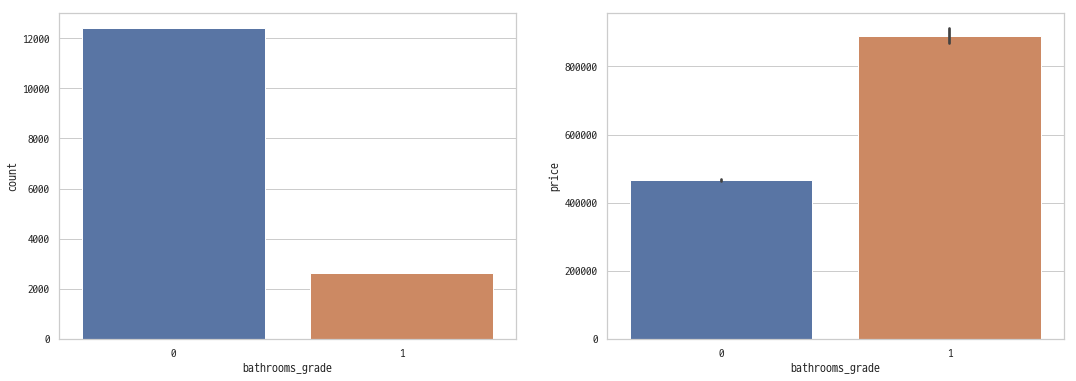

In [20]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="bathrooms_grade", ax=ax1)
sns.barplot(data=data, x="bathrooms_grade", y="price", ax=ax2)
plt.show()

# `floors`

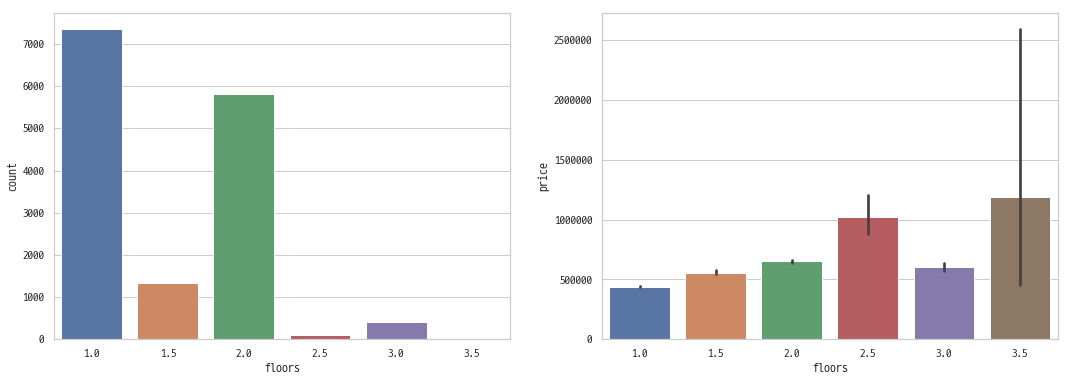

In [21]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="floors", ax=ax1)
sns.barplot(data=data, x="floors", y="price", ax=ax2)
plt.show() 

In [22]:
data.floors.value_counts()

1.0    7361
2.0    5810
1.5    1330
3.0     417
2.5     113
3.5       4
Name: floors, dtype: int64

- 그대로 가져가기에는 편차가 너무 심하고 데이터가 희소
- 1층 / 2층 / upper 으로 이진분류

In [23]:
data['floors_grade'] = data.floors.apply(lambda i: 0 if i < 2 else 1 if i < 2.5 else 2)
data[['floors', 'floors_grade']].head(10)

,floors,floors_grade
id,,
0,1.0,0
1,1.0,0
2,1.0,0
3,2.0,1
4,1.0,0
5,1.0,0
6,1.0,0
7,1.5,0
8,1.0,0


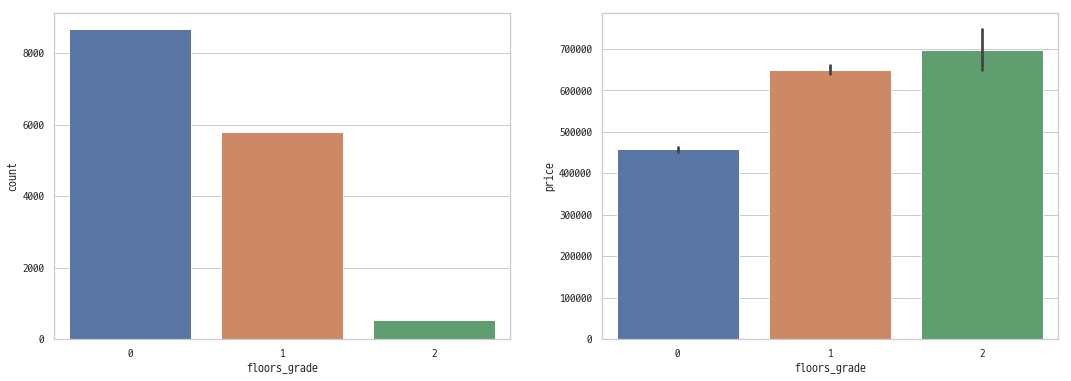

In [24]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="floors_grade", ax=ax1)
sns.barplot(data=data, x="floors_grade", y="price", ax=ax2)
plt.show()

# `waterfront`

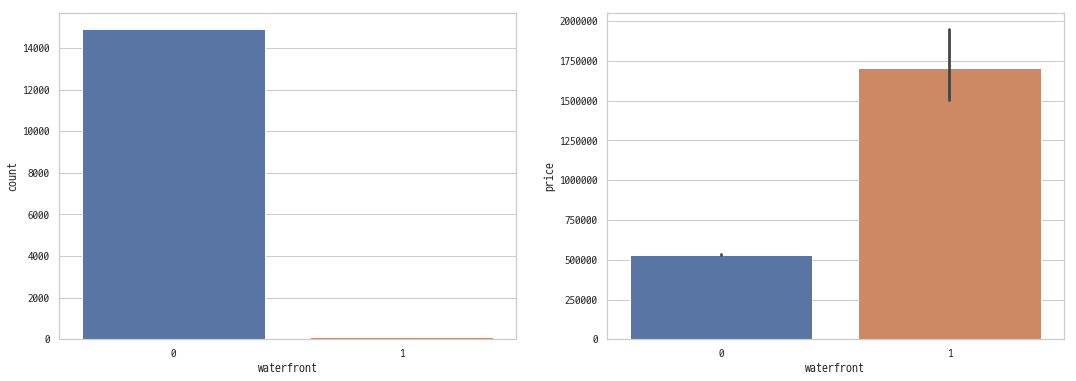

In [25]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="waterfront", ax=ax1)
sns.barplot(data=data, x="waterfront", y="price", ax=ax2)
plt.show() 

- 확연한 차이를 가지므로 그대로 간다.

# `view`

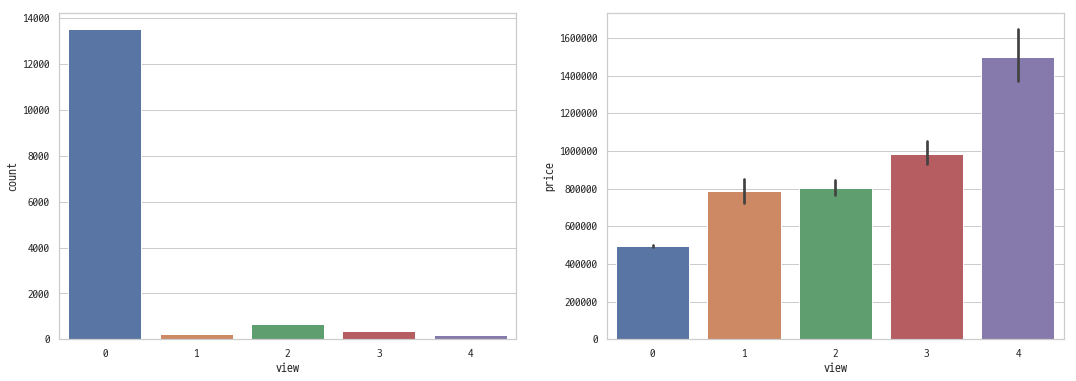

In [26]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="view", ax=ax1)
sns.barplot(data=data, x="view", y="price", ax=ax2)
plt.show() 

In [27]:
data.view.value_counts()

0    13548
2      665
3      373
1      241
4      208
Name: view, dtype: int64

- 뚜렷한 증가를 보여주므로 그대로 간다.

# `condition`

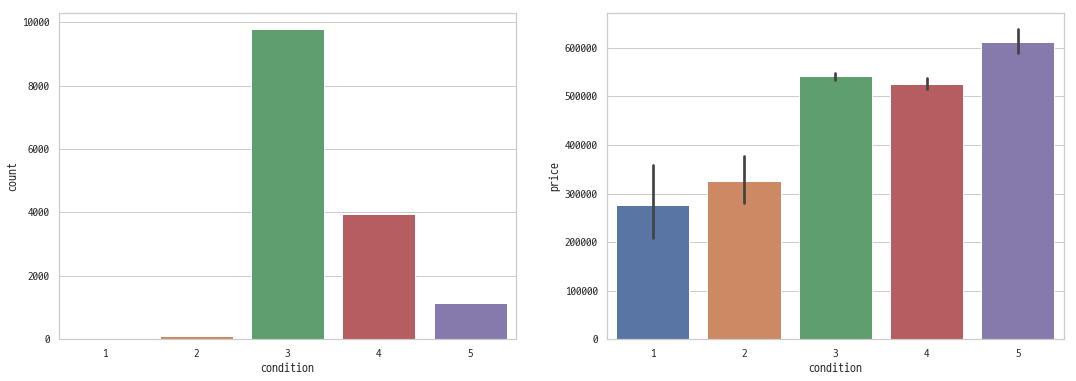

In [28]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="condition", ax=ax1)
sns.barplot(data=data, x="condition", y="price", ax=ax2)
plt.show() 

In [29]:
data.condition.value_counts()

3    9793
4    3956
5    1155
2     110
1      21
Name: condition, dtype: int64

- 1,2 / 3,4 / 5 로 나누도록 하겠다

In [30]:
data['condition_grade'] = data.condition.apply(lambda i: (i-1)//2)
data[['condition', 'condition_grade']].head(10)

,condition,condition_grade
id,,
0,3,1
1,3,1
2,3,1
3,3,1
4,3,1
5,3,1
6,4,1
7,4,1
8,4,1


In [31]:
data[data['condition_grade'] == 0][['condition', 'condition_grade']].head()

,condition,condition_grade
id,,
28,2,0
229,2,0
271,1,0
339,2,0
746,2,0


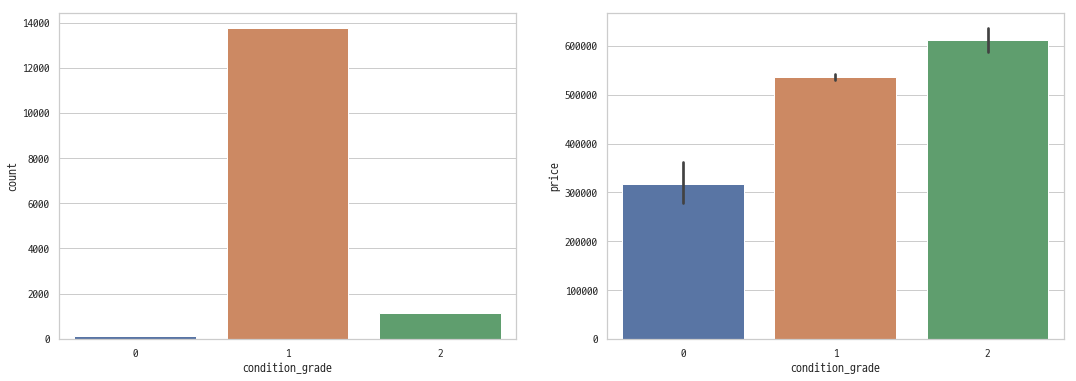

In [32]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="condition_grade", ax=ax1)
sns.barplot(data=data, x="condition_grade", y="price", ax=ax2)
plt.show() 

# `grade`

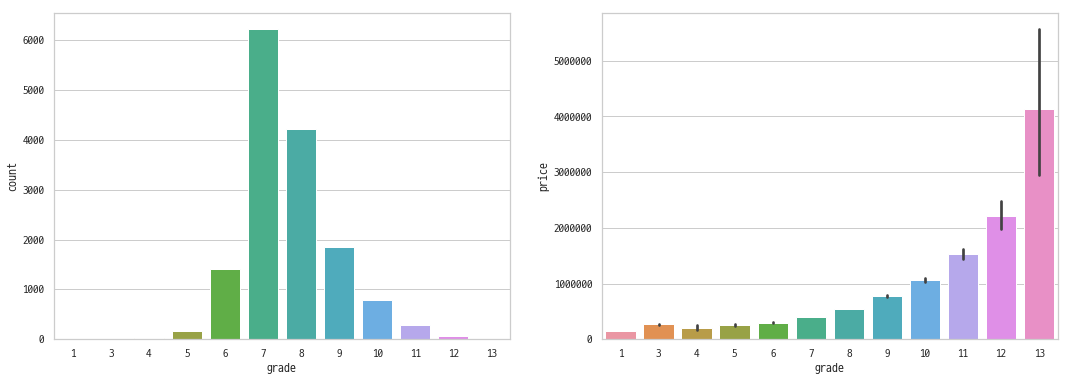

In [33]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="grade", ax=ax1)
sns.barplot(data=data, x="grade", y="price", ax=ax2)
plt.show() 

In [34]:
data.grade.value_counts().reset_index().sort_values(by='index')

,index,grade
11,1,1
10,3,2
8,4,23
6,5,174
3,6,1406
0,7,6228
1,8,4207
2,9,1855
4,10,781
5,11,288


- 1~8 / 9~13으로 나누겠다

In [35]:
data['grade_grade'] = data.grade.apply(lambda i: 0 if i < 9 else 1)
data[['grade', 'grade_grade']].tail()

,grade,grade_grade
id,,
15030,9,1
15031,9,1
15032,8,0
15033,8,0
15034,7,0


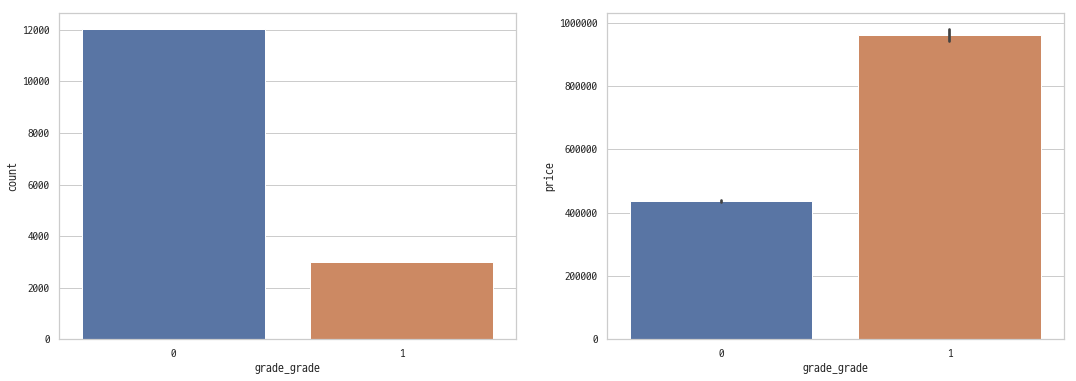

In [36]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="grade_grade", ax=ax1)
sns.barplot(data=data, x="grade_grade", y="price", ax=ax2)
plt.show() 

# `yr_built`

- 뺀다.

# `yr_renovated`

- OHE 데이터로 이용한다.

In [37]:
data['yr_renovated_ohe'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)
data['yr_renovated_ohe'].value_counts()

0    14404
1      631
Name: yr_renovated_ohe, dtype: int64

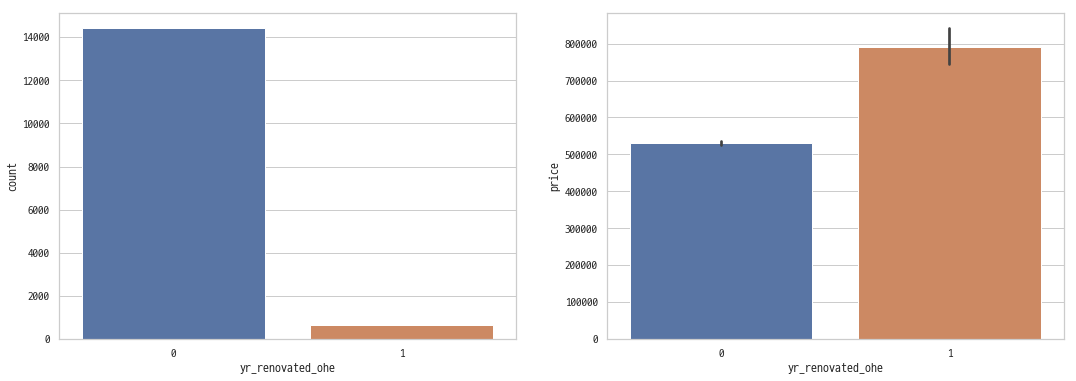

In [38]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 6)

sns.countplot(data=data, x="yr_renovated_ohe", ax=ax1)
sns.barplot(data=data, x="yr_renovated_ohe", y="price", ax=ax2)
plt.show() 

# `zipcode`

In [6]:
zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                              ascending=False).reset_index()[['zipcode', 'price']]
zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
zipcode_rank.head()

,zipcode,price,rank
0,98039,2.245862e+06,1
1,98004,1.397283e+06,2
2,98040,1.204216e+06,3
3,98112,1.118553e+06,4
4,98102,9.043680e+05,5


In [7]:
zipcode_rank_dict = zipcode_rank.set_index(['zipcode'])['rank'].to_dict()
len(zipcode_rank_dict)

70

In [8]:
data['zipcode_rank'] = 71 - data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
data[['zipcode', 'zipcode_rank']].head()

,zipcode,zipcode_rank
id,,
0,98178,13
1,98028,31
2,98074,57
3,98003,7
4,98198,11


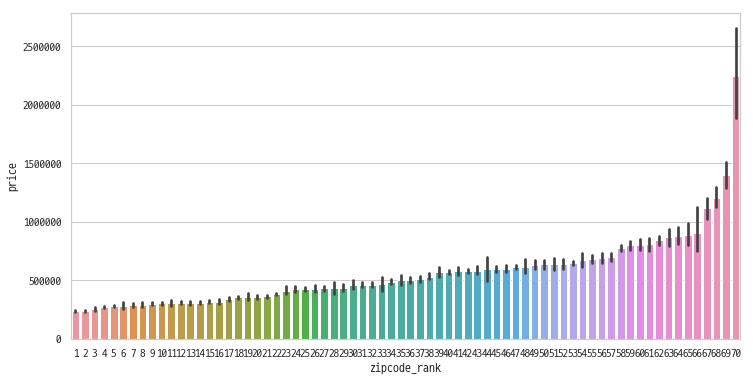

In [9]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="zipcode_rank", y="price")
plt.show()

## zipcode 값 조정해보기

- zipcode rank는 여전히 1~70 사이의 값으로 너무 큰 숫자이므로 standarization 해준다.
- 여기서 높은 rank의 집들은 price가 현저히 높으므로 가중치를 주기 위해서 exp를 씌워준다.

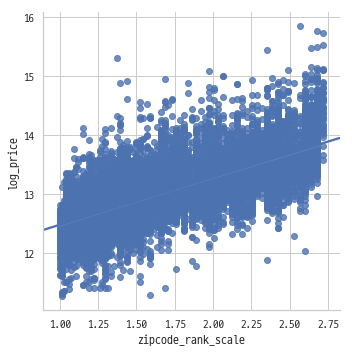

In [10]:
data['zipcode_rank_scale'] = np.exp((data['zipcode_rank'] - data.zipcode_rank.min()) \
                                        / (data.zipcode_rank.max() - data.zipcode_rank.min()))
# data.groupby('zipcode_rank_scale').mean().sort_values('price').reset_index()[['zipcode_rank_scale', 'price']]
sns.lmplot(data=data, x='zipcode_rank_scale', y='log_price')
plt.show()

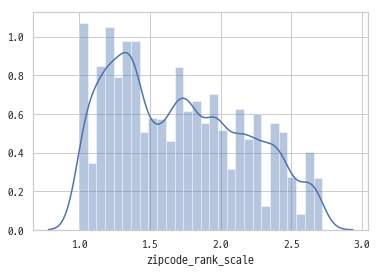

In [67]:
sns.distplot(data['zipcode_rank_scale'])
plt.show()

# `lat`, `long`

In [44]:
data[['lat', 'long']].describe()

,lat,long
count,15035.000000,15035.000000
mean,47.560721,-122.213677
std,0.138164,0.141294
min,47.155900,-122.519000
25%,47.472700,-122.328000
50%,47.571900,-122.231000
75%,47.678300,-122.126000
max,47.777600,-121.315000


- 편차가 너무 작아서 분리되기 어려울 수 있으므로 표준화를 통해 편차를 1로 만들어준다

In [45]:
data['lat_scale'] = (data['lat'] - data['lat'].mean()) / data['lat'].std()
data['long_scale'] = (data['long'] - data['long'].mean()) / data['long'].std()
data[['lat', 'lat_scale', 'long', 'long_scale']].head()

,lat,lat_scale,long,long_scale
id,,,,
0,47.5112,-0.358419,-122.257,-0.306616
1,47.7379,1.282383,-122.233,-0.136758
2,47.6168,0.405889,-122.045,1.193796
3,47.3097,-1.816828,-122.327,-0.802035
4,47.4095,-1.094499,-122.315,-0.717106


In [46]:
data[['lat_scale', 'long_scale']].describe()

,lat_scale,long_scale
count,1.503500e+04,1.503500e+04
mean,2.025886e-15,5.225407e-14
std,1.000000e+00,1.000000e+00
min,-2.929996e+00,-2.160900e+00
25%,-6.370725e-01,-8.091128e-01
50%,8.091373e-02,-1.226034e-01
75%,8.510118e-01,6.205254e-01
max,1.569722e+00,6.360311e+00


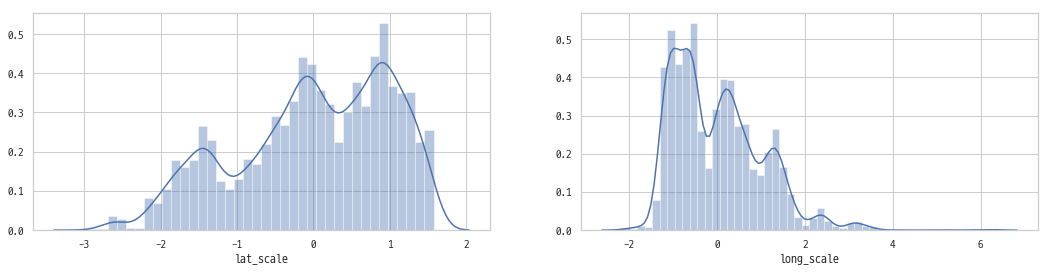

In [47]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.distplot(data['lat_scale'], ax=ax1)
sns.distplot(data['long_scale'], ax=ax2)
plt.show()

# `Areas`

In [48]:
data['sqft_living_scale'] = np.log1p(data['sqft_living'])
data['sqft_lot_scale'] = np.log1p(data['sqft_lot'])

In [49]:
data['sqft_living_diff'] = data['sqft_living15'] - data['sqft_living']
data['sqft_lot_diff'] = data['sqft_lot15'] - data['sqft_lot']

In [50]:
data.loc[data['sqft_living_diff'] < 0, 'sqft_living_diff_scale'] = -np.log1p(-data['sqft_living_diff'])
data.loc[data['sqft_living_diff'] >= 0, 'sqft_living_diff_scale'] = np.log1p(data['sqft_living_diff'])
data.loc[data['sqft_lot_diff'] < 0, 'sqft_lot_diff_scale'] = -np.log1p(-data['sqft_lot_diff'])
data.loc[data['sqft_lot_diff'] >= 0, 'sqft_lot_diff_scale'] = np.log1p(data['sqft_lot_diff'])

In [51]:
data['sqft_above_scale'] = np.log1p(data['sqft_above'])

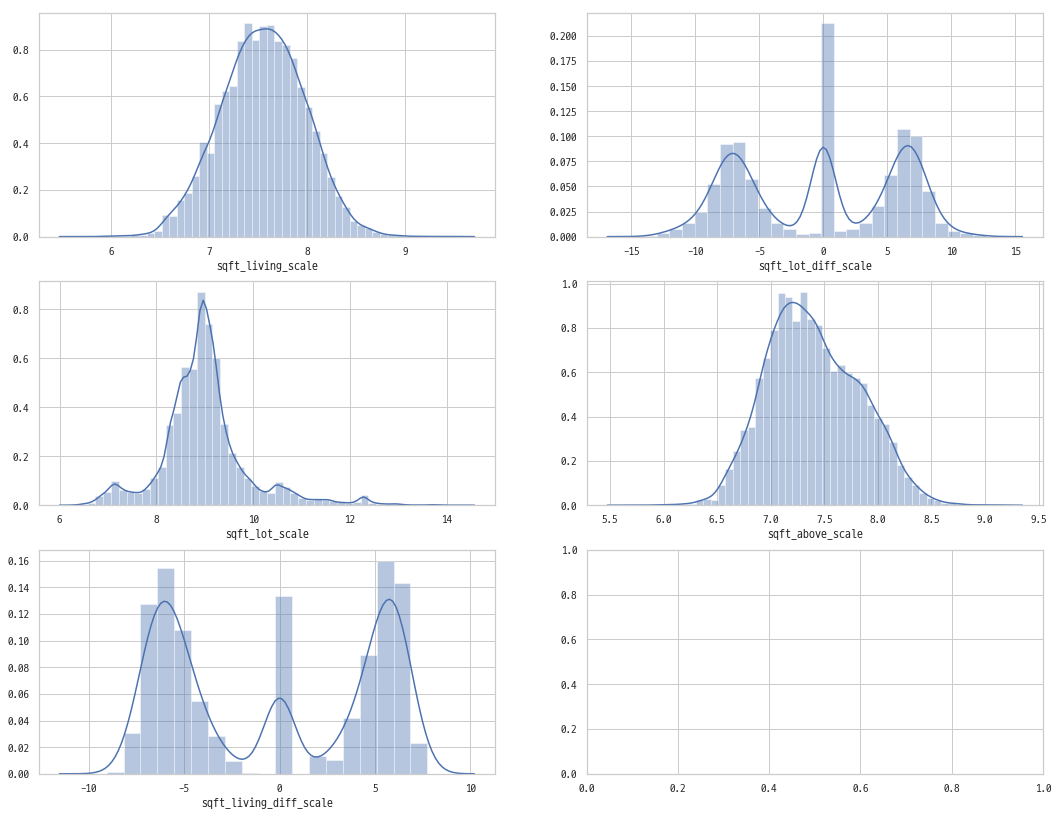

In [52]:
figure, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 14)

sns.distplot(data['sqft_living_scale'], ax=ax1)
sns.distplot(data['sqft_lot_scale'], ax=ax2)
sns.distplot(data['sqft_living_diff_scale'], ax=ax3)
sns.distplot(data['sqft_lot_diff_scale'], ax=ax4)
sns.distplot(data['sqft_above_scale'], ax=ax5)
plt.show()

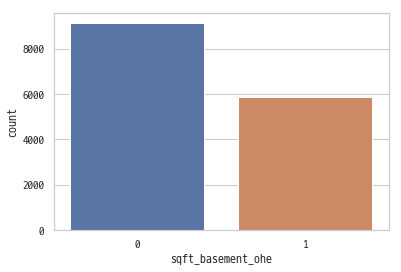

In [53]:
data['sqft_basement_ohe'] = data.sqft_basement.apply(lambda i: 0 if i == 0 else 1)
sns.countplot(data=data, x="sqft_basement_ohe")
plt.show()

---
---

# Feature Selection

In [54]:
all_features = list(data.columns)
print("전체 feature 수:", len(all_features))
print(all_features)

전체 feature 수: 49
['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'log_price', 'year', 'month', 'day', 'year_month', 'day_of_week', '2014_or_not', 'weekday_ohe', 'saturday_ohe', 'sunday_ohe', 'bedrooms_size', 'bedrooms_grade', 'bathrooms_grade', 'floors_grade', 'condition_grade', 'grade_grade', 'yr_renovated_ohe', 'zipcode_rank', 'zipcode_rank_scale', 'lat_scale', 'long_scale', 'sqft_living_scale', 'sqft_lot_scale', 'sqft_living_diff', 'sqft_lot_diff', 'sqft_living_diff_scale', 'sqft_lot_diff_scale', 'sqft_above_scale', 'sqft_basement_ohe']


## not using features

- `date` : datetime으로 parsing해서 분해
- `price` : log 변환해서 기존의 price는 사용 x

In [55]:
no_use = ['date', 'price', 'yr_built', 'month', 'day', 'year_month', 'bedrooms_size']
len(no_use)

7

### target value

In [56]:
label = ['log_price']
len(label)

1

### time features

In [57]:
times = ['year', 'day_of_week']
times_ohe = ['2014_or_not', 'weekday_ohe', 'saturday_ohe', 'sunday_ohe']

len(times), len(times_ohe)

(2, 4)

### grading 된 features

In [58]:
before_grading = ['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode']
after_grading = ['bedrooms_grade', 'bathrooms_grade', 'floors_grade', 'condition_grade', \
                 'grade_grade', 'zipcode_rank']

len(before_grading), len(after_grading)

(6, 6)

### OHE 된 features

In [59]:
before_ohe = ['yr_renovated', 'sqft_basement']
after_ohe = ['yr_renovated_ohe', 'sqft_basement_ohe']

len(before_ohe), len(after_ohe)

(2, 2)

### scaling 된 features

In [60]:
before_scaling = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', \
                  'sqft_living_diff', 'sqft_lot_diff', 'lat', 'long']
after_scaling = ['sqft_living_scale', 'sqft_lot_scale', 'sqft_living_diff_scale', 'sqft_lot_diff_scale', \
                 'sqft_above_scale', 'lat_scale', 'long_scale']

len(before_scaling), len(after_scaling)

(9, 7)

### 그대로인 features

In [61]:
same = ['waterfront', 'view']
len(same)

2

### 개수 확인

In [62]:
len(no_use) + len(label) + len(times) + len(times_ohe) + len(before_grading) + len(after_grading)\
+ len(before_ohe) + len(after_ohe) + len(before_scaling) + len(after_scaling) + len(same)

48

## 사용할 features

In [63]:
label

['log_price']

In [75]:
features = times_ohe + before_grading + after_ohe + after_scaling + same
print(len(features))
features

21


['2014_or_not',
 'weekday_ohe',
 'saturday_ohe',
 'sunday_ohe',
 'bedrooms',
 'bathrooms',
 'floors',
 'condition',
 'grade',
 'zipcode',
 'yr_renovated_ohe',
 'sqft_basement_ohe',
 'sqft_living_scale',
 'sqft_lot_scale',
 'sqft_living_diff_scale',
 'sqft_lot_diff_scale',
 'sqft_above_scale',
 'lat_scale',
 'long_scale',
 'waterfront',
 'view']

In [76]:
train = data[features]

---

## Skewness 확인

In [77]:
skews = {}
for column in train.columns:
    skews[column] = np.round(skew(train[column]), 4)

skew_df = pd.DataFrame(skews, index=['skewness']).T.sort_values('skewness', ascending=False)
skew_df

,skewness
waterfront,11.7269
sunday_ohe,10.3322
saturday_ohe,8.5409
yr_renovated_ohe,4.5685
view,3.3784
condition,1.0440
sqft_lot_scale,0.9898
long_scale,0.9179
2014_or_not,0.7734
grade,0.7516


- ohe 컬럼 제외, skew 높은 값들 확인해보자

### `long_scale`

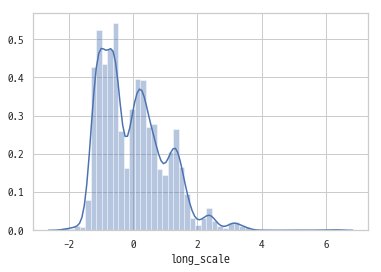

In [78]:
sns.distplot(data['long_scale'])
plt.show()

- scaling을 한번 더 해주도록 하자
- 음수를 없애기 위해 min값을 빼준 후 log 씌우기

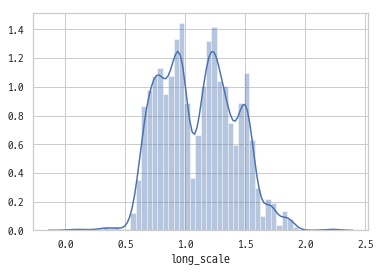

In [79]:
sns.distplot(np.log1p(data["long_scale"] - data['long_scale'].min()))
plt.show()

In [80]:
skew(np.log1p(data["long_scale"] - data['long_scale'].min()))

0.19065413094177408

- 많이 내려갔다

## `sqft_lot_scale`

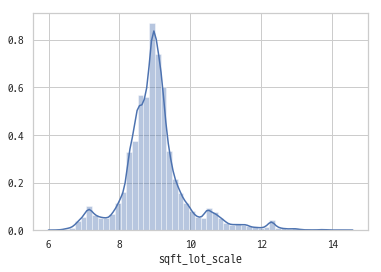

In [482]:
sns.distplot(train['sqft_lot_scale'])
plt.show()

- log를 한 번 더 해주자

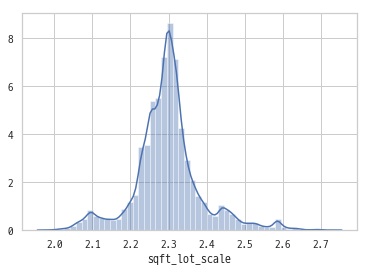

In [81]:
sns.distplot(np.log1p(train['sqft_lot_scale']))
plt.show()

In [82]:
skew(np.log1p(train['sqft_lot_scale']))

0.43172675062823546